In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [257]:
model = 'Ising'
nn_model = 'ResNet-18'
tc = 2/np.log(1+2**0.5)

base_dir = 'resnet18/'
files = {
    24: 'epoch0_test.csv',
    48: 'epoch5_test.csv',
    72: 'epoch3_test.csv',
    96: 'epoch0_test.csv',
    144: 'epoch3_test.csv',
    216: 'epoch7_test.csv',
}
colors = ['blue', 'orange', 'green', 'red', 'violet', 'black']

Ls = np.array(sorted(list(files.keys())))

In [248]:
all_dfs = [pd.read_csv(f"{base_dir}L{k}/{v}") for k,v in files.items()]
df = pd.concat(all_dfs)
df.head(2)

,L,T,f_proba,p_proba,true
0,24,2.099185,0.822948,0.177052,0
1,24,2.099185,0.935239,0.064761,0


In [249]:
stats = df.groupby(['L','T']).agg(
    ft=('f_proba', np.mean),
    vt=('f_proba', np.var),
    ft_err=('f_proba', lambda x: np.std(x)/np.sqrt(len(x))))\
    .reset_index()
stats.head(2)

,L,T,ft,vt,ft_err
0,24,1.819185,0.986400,0.000432,0.000929
1,24,1.869185,0.978408,0.000578,0.001074


## F(T, L)

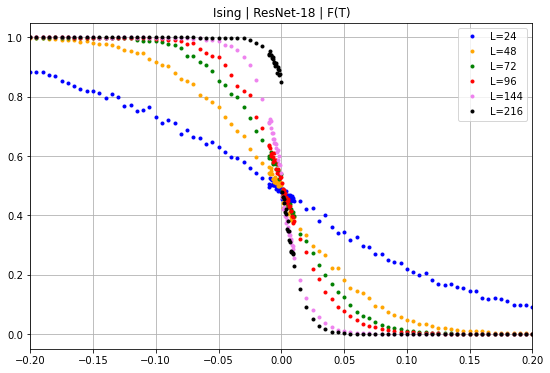

In [259]:
plt.figure(figsize=(9,6))
for idx, L in enumerate(Ls):
    curr = stats[stats.L == L]
    plt.plot(
        curr['T'].values-tc,
        curr['ft'].values,
        '.',
        label=f"L={L}",
        c=colors[idx]
    )
plt.title(f"{model} | {nn_model} | F(T)")
plt.xlim((-.2,.2))
plt.grid()
plt.legend()

## V(T, L)

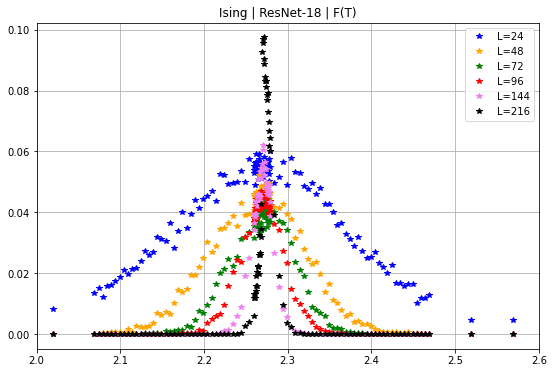

In [261]:
plt.figure(figsize=(9,6))
for idx, L in enumerate(Ls):
    curr = stats[ (stats.L == L)]
    x, y = curr['T'].values, curr['vt'].values
    plt.plot(
        x, y,
        '*',
        label=f"L={L}",
        color=colors[idx]
    )
plt.xlim((2.0,2.6))
plt.title(f"{model} | {nn_model} | F(T)")
plt.grid()
plt.legend()

## Fit V-curve

In [262]:
def f_gauss(x, k, stdx, meanx):
    """gauss scaled probability density function (pdf) => k*pdf"""
    return k/(stdx*(np.pi*2)**0.5)*np.exp(-1/2*( (x-meanx)/stdx)**2)


def fit_gauss(x, y, **set_prms):
    set_prms['xmin'] = set_prms.get('xmin', x.min())
    set_prms['xmax'] = set_prms.get('xmax', x.max())
    set_prms['ymin'] = set_prms.get('ymin', y.min())
    set_prms['p0'] = set_prms.get('p0', [0.1,0.1,tc])
    set_prms['abs_sigma'] = set_prms.get('abs_sigma', False)
    set_prms['maxfev'] = set_prms.get('maxfev', 10**5)

    x_filtr = ((x >= set_prms['xmin']) & (x <=set_prms['xmax']))
    y_filtr = (y >= set_prms['ymin'] ) 
    
    filtr = y_filtr * x_filtr
    x_ = x[filtr]; y_ = y[filtr]
    
    params, cov = curve_fit(
        f_gauss, xdata = x_, ydata = y_,
        p0 = set_prms['p0'],
        absolute_sigma=set_prms['abs_sigma'], 
        maxfev=set_prms['maxfev'])
    
    params_err = np.sqrt(np.diag(cov))
    return params, params_err, set_prms


def f_linear(x, a, b):
    """linear function"""
    return a*x + b 

def linear_fit(val, val_err, L, abs_sigma=False, maxfev=10**4):
    """make fitting for given values, values_errors, L
        :return parameters estimation, errors
    """
    
    params, cov = curve_fit(f_linear, xdata = np.log10(1/L), ydata = np.log10(val),
                        sigma = np.log10(val_err), absolute_sigma = abs_sigma, maxfev=maxfev)
    return (params, np.sqrt(np.diag(cov)))


def make_plot(val, val_err, L, fit_prms):
    plt.plot(1/L, val, '*', c='blue', label='data')
    plt.errorbar(1/L, val, yerr=val_err, fmt='none', c='blue')
    prms, prms_err = fit_prms
    a,b = np.round(prms,3)
    a_err, b_err = np.round(prms_err, 3)
    L_inf = np.linspace(10, 500, 1000)
    plt.plot(1/L_inf, 10**b*(1/L_inf)**a, c='darkblue', alpha=0.5, 
             label=r"fit, $\nu$="+f" {a} "+r"$\pm$"+f" {a_err}")

## Make some single fits
Fit V-curve with Gauss-curve to extract mean, sigma.  
Repeat for every lattice size L:  
- set L, fitting parameters
- store results in the next cell array

{96: {'setting': {'xmin': 2.2, 'xmax': 2.35, 'ymin': 0.01, 'p0': [0.1, 0.1, 2.269185314213022], 'abs_sigma': False, 'maxfev': 100000}, 'prms': [0.002815481264859638, 0.025728285663864058, 2.2698876483866575], 'prms_err': [5.854121384380828e-05, 0.0005817856903867744, 0.0004979215811592022]}}


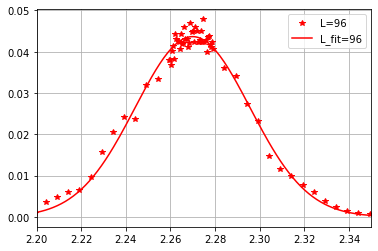

In [263]:
idx = 3
set_prms = dict(
    xmin=2.2,
    xmax=2.35,
    ymin=0.01
)


L = Ls[idx]
curr = stats[ (stats.L == L)]
x, y = curr['T'].values, curr['vt'].values
plt.plot(
    x, y,
    '*',
    label=f"L={L}",
    color=colors[idx]
)

prms, prms_err, settings = fit_gauss(x,y, **set_prms)
x_fit = np.linspace(x.min(), x.max(), 1000)
y_fit = f_gauss(x_fit, *prms)
plt.plot(
    x_fit, y_fit,
    '-',
    label=f"L_fit={L}",
    color=colors[idx]
)
plt.xlim((settings['xmin'], settings['xmax']))
plt.grid()
plt.legend()
print({
    Ls[idx]: {
        'setting': settings,
        'prms': prms.tolist(),
        'prms_err': prms_err.tolist()
    }
})

In [154]:
prms_array = [
{24: {'setting': {'xmin': 2.0,'xmax': 2.6,'ymin': 0.01,'p0': [0.1, 0.1, 2.269185314213022],'abs_sigma': False,'maxfev': 100000},'prms': [0.01509721, 0.1100013 , 2.26753711],'prms_err': [0.00014638, 0.00118346, 0.0011772 ]}},
{48: {'setting': {'xmin': 2.1,'xmax': 2.4,'ymin': 0.01,'p0': [0.1, 0.1, 2.269185314213022],'abs_sigma': False,'maxfev': 100000},'prms': [0.00653765, 0.05883409, 2.26494887],'prms_err': [0.00012465, 0.00122672, 0.00117896]}},
{72: {'setting': {'xmin': 2.2,'xmax': 2.4,'ymin': 0.01,'p0': [0.1, 0.1, 2.269185314213022],'abs_sigma': False,'maxfev': 100000},'prms': [0.0039903 , 0.0410288 , 2.27279213],'prms_err': [0.00011247, 0.00124801, 0.00106537]}},
{96: {'setting': {'xmin': 2.2,'xmax': 2.35,'ymin': 0.01,'p0': [0.1, 0.1, 2.269185314213022],'abs_sigma': False,'maxfev': 100000},'prms': [0.00281548, 0.02572829, 2.26988765],'prms_err': [5.85412138e-05, 5.81785690e-04, 4.97921581e-04]}},
{144: {'setting': {'xmin': 2.24,'xmax': 2.3,'ymin': 0.01,'p0': [0.1, 0.1, 2.269185314213022],'abs_sigma': False,'maxfev': 100000},'prms': [1.65793894e-03, 1.23023062e-02, 2.27056376e+00],'prms_err': [5.09684668e-05, 4.54130159e-04, 2.85479322e-04]}},
{216: {'setting': {'xmin': 2.24, 'xmax': 2.35, 'ymin': 0.0, 'p0': [0.1, 0.1, 2.269185314213022], 'abs_sigma': False, 'maxfev': 100000}, 'prms': [1.25142725e-03, 5.67468127e-03, 2.27384824e+00], 'prms_err': [5.43089080e-05, 2.94143668e-04, 2.79225291e-04]}}
]

In [155]:
reduced_prms = {}
[reduced_prms.update(d) for d in prms_array]
print('reduced')

reduced


## Fit sigma

In [226]:
sigma = [reduced_prms[L].get('prms')[1] for L in Ls]
sigma_err = [reduced_prms[L].get('prms_err')[1] for L in Ls]

In [241]:
fit_prms = linear_fit(sigma[1:], sigma_err[1:], Ls[1:])  # skip small sizes
print(fit_prms)

(array([1.56997966, 1.4730295 ]), array([0.13243175, 0.26252499]))


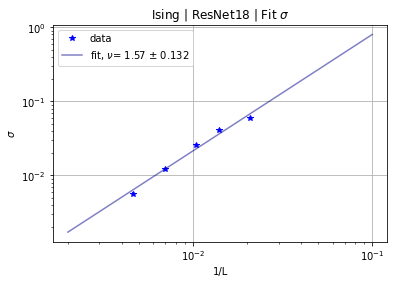

In [242]:
make_plot(sigma[1:], sigma_err[1:], Ls[1:], fit_prms)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Ising | ResNet18 | Fit $\sigma$')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.legend()

## All V-curves combined

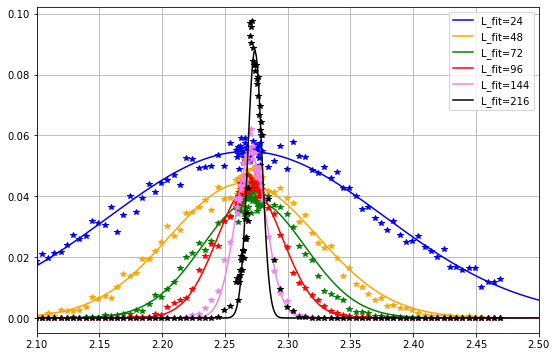

In [266]:
plt.figure(figsize=(9,6))
for idx, L in enumerate(Ls):
    curr = stats[ (stats.L == L)]
    x, y = curr['T'].values, curr['vt'].values
    plt.plot(
        x, y,
        '*',
        color=colors[idx]
    )
    curr_prms = reduced_prms.get(L)['prms']
    x_fit = np.linspace(x.min(), x.max(), 1000)
    y_fit = f_gauss(x_fit, *curr_prms)
    plt.plot(
        x_fit, y_fit,
        '-',
        label=f"L_fit={L}",
        color=colors[idx]
    )
plt.xlim((2.1,2.5))
plt.grid()
plt.legend()